In [1]:
from google.cloud import storage
from google.oauth2 import service_account
import numpy as np
import os
from pathlib import Path
import csv

from colearn_examples.config import ColearnConfig, TrainingData, ModelConfig
from colearn_examples.xray import prepare_single_client, XrayConfig

import matplotlib.pyplot as plt

In [2]:
def download_data_from_gcloud(cloud_data_dir, local_data_dir, credentials=None):
    bucket_name = cloud_data_dir.replace('gs://', '')
    bucket_name, prefix = bucket_name.split('/', 1)
    print("DOWNLOAD DATA FROM GCLOUD, bucket=",bucket_name, ", prefix=", prefix)

    storage_client = storage.Client(credentials=credentials)
    bucket = storage_client.bucket(bucket_name=bucket_name)
    blobs = bucket.list_blobs(prefix=prefix+"/")  # Get list of files

    local_full_path = Path(local_data_dir) / prefix
    os.makedirs(local_full_path, exist_ok=True)
    file_counter = 0
    for blob in blobs:
        filename = blob.name
        if filename.find(prefix+"/") == -1:
            continue
        #print("Blob name: ", filename)
        blob.download_to_filename(Path(local_data_dir) / filename)  # Download
        file_counter += 1

    if file_counter == 0:
        raise Exception("No data in folder: " + cloud_data_dir)

    return local_full_path


def get_data(data_dir, credentials=None):
    if str(data_dir).startswith("gs://"):
        return download_data_from_gcloud(data_dir, '/tmp/data_download', credentials=credentials)
    return data_dir

def model_factory(n_learners,data_root, test_root, i):
    print("CREATE LEARNER: ",i)
    colearn_config = ColearnConfig(task=TrainingData["XRAY"],n_learners=n_learners, seed=10)
    learner_config = XrayConfig(colearn_config.shuffle_seed)

    credentials_path = "/Users/qati/code/infra-mlfabric/config/fetch-ai-sandbox-mlfabric.json"
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=credentials_path
    credentials = service_account.Credentials.from_service_account_file(
        credentials_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
    )
    
    data_dir="{}{}".format(data_root, i)
    test_dir="{}".format(test_root)


    local_data_dir = get_data(data_dir, credentials=credentials)
    print("GCLOUD data downloaded to ", local_data_dir)
    local_test_dir = get_data(test_dir, credentials=credentials)
    print("GCLOUD data downloaded to ", local_test_dir)
    
    learner_data = prepare_single_client(learner_config, local_data_dir,local_test_dir)

    return learner_config.model_type(config=learner_config, data=learner_data)

def train_nodes(learners):
    val_acc = []
    test_acc =[]
    train_acc =[]
    for l in learners:
        tra = l._train_model()
        w = l.get_weights()
        pw = l.test_model(w)
        train_acc.append(tra)
        test_acc.append(pw.test_accuracy)
        val_acc.append(pw.vote_accuracy)
    return train_acc, val_acc, test_acc

In [3]:
data_root = "gs://mlfabric/xray5_" #"gs://mlfabric/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_"
test_root = "gs://mlfabric/chestXray_test0"
n_learners=5

learners = []
for i in range(n_learners):
    learners.append(model_factory(n_learners, data_root, test_root, i))

CREATE LEARNER:  0
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_0
GCLOUD data downloaded to  /tmp/data_download/xray5_0
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= chestXray_test0
GCLOUD data downloaded to  /tmp/data_download/chestXray_test0


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 32)      320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 128, 32)      128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0     

Validating: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


AUC score: 0.4223372781065089
Confusion martrix:
 [[51  1]
 [52  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.98      0.66        52
           1       0.00      0.00      0.00        52

    accuracy                           0.49       104
   macro avg       0.25      0.49      0.33       104
weighted avg       0.25      0.49      0.33       104

CREATE LEARNER:  1
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_1
GCLOUD data downloaded to  /tmp/data_download/xray5_1
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= chestXray_test0


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/chestXray_test0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 32)      320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 128, 32)      128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 64)        256       
_______________________________________________________________

Validating: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC score: 0.5055473372781065
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

CREATE LEARNER:  2
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_2
GCLOUD data downloaded to  /tmp/data_download/xray5_2
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= chestXray_test0


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/chestXray_test0
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 32)      320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 128, 32)      128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 64)        256       
_______________________________________________________________

Validating: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC score: 0.3387573964497042
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

CREATE LEARNER:  3
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_3
GCLOUD data downloaded to  /tmp/data_download/xray5_3
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= chestXray_test0


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/chestXray_test0
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 32)      320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 128, 32)      128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 64)        256       
_______________________________________________________________

Validating: 100%|██████████| 13/13 [00:02<00:00,  5.33it/s]


AUC score: 0.5340236686390533
Confusion martrix:
 [[ 4 48]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.57      0.08      0.14        52
           1       0.51      0.94      0.66        52

    accuracy                           0.51       104
   macro avg       0.54      0.51      0.40       104
weighted avg       0.54      0.51      0.40       104

CREATE LEARNER:  4
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_4
GCLOUD data downloaded to  /tmp/data_download/xray5_4
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= chestXray_test0


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/chestXray_test0
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 32)      320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 128, 32)      128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 64)        256       
_______________________________________________________________

Validating: 100%|██████████| 13/13 [00:02<00:00,  4.71it/s]

AUC score: 0.6190828402366865
Confusion martrix:
 [[51  1]
 [50  2]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.98      0.67        52
           1       0.67      0.04      0.07        52

    accuracy                           0.51       104
   macro avg       0.59      0.51      0.37       104
weighted avg       0.59      0.51      0.37       104



In [ ]:
epochs = 50

train_acc = {}
val_acc = {}
test_acc = {}

for i in range(n_learners):
    train_acc[i] = []
    val_acc[i] = []
    test_acc[i] = []

for e in range(epochs):
    print("Epoch: ", e)
    tra, v, tsa = train_nodes(learners)
    for i in range(n_learners):
        train_acc[i].append(tra[i])
        val_acc[i].append(v[i])
        test_acc[i].append(tsa[i])

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.86it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.85it/s]

AUC score: 0.7237426035502958
Confusion martrix:
 [[45  7]
 [32 20]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.87      0.70        52
           1       0.74      0.38      0.51        52

    accuracy                           0.62       104
   macro avg       0.66      0.62      0.60       104
weighted avg       0.66      0.62      0.60       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.642954883622064
Confusion martrix:
 [[289  99]
 [216 172]]
Classification report:
               precision    recall  f1-score   support

           0       0.57      0.74      0.65       388
           1       0.63      0.44      0.52       388

    accuracy                           0.59       776
   macro avg       0.60      0.59      0.58       776
weighted avg       0.60      0.59      0.58       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.47it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:15,  6.33it/s]

AUC score: 0.5617603550295858
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Testing: 100%|██████████| 97/97 [00:14<00:00,  7.62it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.45850382612392393
Confusion martrix:
 [[  0 388]
 [  0 388]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.50      1.00      0.67       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:15,  6.31it/s]

AUC score: 0.4086538461538462
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.5367533744287385
Confusion martrix:
 [[  0 388]
 [  1 387]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.50      1.00      0.67       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.41it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.81it/s]

AUC score: 0.5650887573964497
Confusion martrix:
 [[12 40]
 [14 38]]
Classification report:
               precision    recall  f1-score   support

           0       0.46      0.23      0.31        52
           1       0.49      0.73      0.58        52

    accuracy                           0.48       104
   macro avg       0.47      0.48      0.45       104
weighted avg       0.47      0.48      0.45       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.573772451907748
Confusion martrix:
 [[ 68 320]
 [ 60 328]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.18      0.26       388
           1       0.51      0.85      0.63       388

    accuracy                           0.51       776
   macro avg       0.52      0.51      0.45       776
weighted avg       0.52      0.51      0.45       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.27it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.61it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:16,  5.82it/s]

AUC score: 0.8295118343195266
Confusion martrix:
 [[52  0]
 [52  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       0.00      0.00      0.00        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Testing: 100%|██████████| 97/97 [00:15<00:00,  6.64it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6270924115208842
Confusion martrix:
 [[388   0]
 [388   0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       388
           1       0.00      0.00      0.00       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776

Epoch:  1


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.19it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.76it/s]

AUC score: 0.7710798816568047
Confusion martrix:
 [[44  8]
 [23 29]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.85      0.74        52
           1       0.78      0.56      0.65        52

    accuracy                           0.70       104
   macro avg       0.72      0.70      0.70       104
weighted avg       0.72      0.70      0.70       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6597141035179084
Confusion martrix:
 [[215 173]
 [128 260]]
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.55      0.59       388
           1       0.60      0.67      0.63       388

    accuracy                           0.61       776
   macro avg       0.61      0.61      0.61       776
weighted avg       0.61      0.61      0.61       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.76it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:12,  7.56it/s]

AUC score: 0.44637573964497046
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Testing: 100%|██████████| 97/97 [00:16<00:00,  6.28it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.46779014773089594
Confusion martrix:
 [[  0 388]
 [  0 388]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.50      1.00      0.67       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.15it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.54it/s]

AUC score: 0.6627218934911242
Confusion martrix:
 [[ 2 50]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07        52
           1       0.51      1.00      0.68        52

    accuracy                           0.52       104
   macro avg       0.75      0.52      0.37       104
weighted avg       0.75      0.52      0.37       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.5962974279944734
Confusion martrix:
 [[  8 380]
 [  2 386]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.02      0.04       388
           1       0.50      0.99      0.67       388

    accuracy                           0.51       776
   macro avg       0.65      0.51      0.35       776
weighted avg       0.65      0.51      0.35       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.57it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:11,  8.05it/s]

AUC score: 0.7821745562130178
Confusion martrix:
 [[45  7]
 [26 26]]
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.87      0.73        52
           1       0.79      0.50      0.61        52

    accuracy                           0.68       104
   macro avg       0.71      0.68      0.67       104
weighted avg       0.71      0.68      0.67       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6675789138059305
Confusion martrix:
 [[269 119]
 [183 205]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.69      0.64       388
           1       0.63      0.53      0.58       388

    accuracy                           0.61       776
   macro avg       0.61      0.61      0.61       776
weighted avg       0.61      0.61      0.61       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.10it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:14,  6.77it/s]

AUC score: 0.8738905325443787
Confusion martrix:
 [[52  0]
 [52  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       0.00      0.00      0.00        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Testing: 100%|██████████| 97/97 [00:16<00:00,  6.20it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8074184291635669
Confusion martrix:
 [[388   0]
 [388   0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       388
           1       0.00      0.00      0.00       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776

Epoch:  2


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.06it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:15,  6.37it/s]

AUC score: 0.8505917159763313
Confusion martrix:
 [[46  6]
 [21 31]]
Classification report:
               precision    recall  f1-score   support

           0       0.69      0.88      0.77        52
           1       0.84      0.60      0.70        52

    accuracy                           0.74       104
   macro avg       0.76      0.74      0.73       104
weighted avg       0.76      0.74      0.73       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6990713678393028
Confusion martrix:
 [[272 116]
 [165 223]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.66       388
           1       0.66      0.57      0.61       388

    accuracy                           0.64       776
   macro avg       0.64      0.64      0.64       776
weighted avg       0.64      0.64      0.64       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:03<00:00,  4.48it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:16,  5.87it/s]

AUC score: 0.4275147928994083
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.4568631097885004
Confusion martrix:
 [[  0 388]
 [  1 387]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.50      1.00      0.67       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:15,  6.12it/s]

AUC score: 0.5824704142011834
Confusion martrix:
 [[ 9 43]
 [11 41]]
Classification report:
               precision    recall  f1-score   support

           0       0.45      0.17      0.25        52
           1       0.49      0.79      0.60        52

    accuracy                           0.48       104
   macro avg       0.47      0.48      0.43       104
weighted avg       0.47      0.48      0.43       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6353889892655968
Confusion martrix:
 [[ 74 314]
 [ 49 339]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.19      0.29       388
           1       0.52      0.87      0.65       388

    accuracy                           0.53       776
   macro avg       0.56      0.53      0.47       776
weighted avg       0.56      0.53      0.47       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.65it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.52it/s]

AUC score: 0.7821745562130177
Confusion martrix:
 [[47  5]
 [34 18]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.90      0.71        52
           1       0.78      0.35      0.48        52

    accuracy                           0.62       104
   macro avg       0.68      0.62      0.59       104
weighted avg       0.68      0.62      0.59       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6822125092996069
Confusion martrix:
 [[302  86]
 [214 174]]
Classification report:
               precision    recall  f1-score   support

           0       0.59      0.78      0.67       388
           1       0.67      0.45      0.54       388

    accuracy                           0.61       776
   macro avg       0.63      0.61      0.60       776
weighted avg       0.63      0.61      0.60       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.34it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:15,  6.30it/s]

AUC score: 0.9012573964497042
Confusion martrix:
 [[52  0]
 [52  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       0.00      0.00      0.00        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8021774364969709
Confusion martrix:
 [[388   0]
 [379   9]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.67       388
           1       1.00      0.02      0.05       388

    accuracy                           0.51       776
   macro avg       0.75      0.51      0.36       776
weighted avg       0.75      0.51      0.36       776

Epoch:  3


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.81it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.93it/s]

AUC score: 0.9219674556213018
Confusion martrix:
 [[51  1]
 [33 19]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.98      0.75        52
           1       0.95      0.37      0.53        52

    accuracy                           0.67       104
   macro avg       0.78      0.67      0.64       104
weighted avg       0.78      0.67      0.64       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6937307365288554
Confusion martrix:
 [[336  52]
 [263 125]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.87      0.68       388
           1       0.71      0.32      0.44       388

    accuracy                           0.59       776
   macro avg       0.63      0.59      0.56       776
weighted avg       0.63      0.59      0.56       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.19it/s]

Getting vote accuracy:


Testing:   0%|          | 0/97 [00:00<?, ?it/s]

AUC score: 0.46856508875739644
Confusion martrix:
 [[ 4 48]
 [ 7 45]]
Classification report:
               precision    recall  f1-score   support

           0       0.36      0.08      0.13        52
           1       0.48      0.87      0.62        52

    accuracy                           0.47       104
   macro avg       0.42      0.47      0.37       104
weighted avg       0.42      0.47      0.37       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.4277553406313105
Confusion martrix:
 [[ 14 374]
 [ 50 338]]
Classification report:
               precision    recall  f1-score   support

           0       0.22      0.04      0.06       388
           1       0.47      0.87      0.61       388

    accuracy                           0.45       776
   macro avg       0.35      0.45      0.34       776
weighted avg       0.35      0.45      0.34       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   0%|          | 0/97 [00:00<?, ?it/s]

AUC score: 0.6283284023668638
Confusion martrix:
 [[47  5]
 [36 16]]
Classification report:
               precision    recall  f1-score   support

           0       0.57      0.90      0.70        52
           1       0.76      0.31      0.44        52

    accuracy                           0.61       104
   macro avg       0.66      0.61      0.57       104
weighted avg       0.66      0.61      0.57       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6480032415772132
Confusion martrix:
 [[313  75]
 [267 121]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.81      0.65       388
           1       0.62      0.31      0.41       388

    accuracy                           0.56       776
   macro avg       0.58      0.56      0.53       776
weighted avg       0.58      0.56      0.53       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.15it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.73it/s]

AUC score: 0.8139792899408284
Confusion martrix:
 [[52  0]
 [45  7]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70        52
           1       1.00      0.13      0.24        52

    accuracy                           0.57       104
   macro avg       0.77      0.57      0.47       104
weighted avg       0.77      0.57      0.47       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6796816877457754
Confusion martrix:
 [[367  21]
 [321  67]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68       388
           1       0.76      0.17      0.28       388

    accuracy                           0.56       776
   macro avg       0.65      0.56      0.48       776
weighted avg       0.65      0.56      0.48       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.92it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:17,  5.53it/s]

AUC score: 0.9197485207100592
Confusion martrix:
 [[52  0]
 [47  5]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        52
           1       1.00      0.10      0.18        52

    accuracy                           0.55       104
   macro avg       0.76      0.55      0.43       104
weighted avg       0.76      0.55      0.43       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8095307684132214
Confusion martrix:
 [[386   2]
 [340  48]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.99      0.69       388
           1       0.96      0.12      0.22       388

    accuracy                           0.56       776
   macro avg       0.75      0.56      0.46       776
weighted avg       0.75      0.56      0.46       776

Epoch:  4


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:11,  8.23it/s]

AUC score: 0.8968195266272189
Confusion martrix:
 [[52  0]
 [46  6]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        52
           1       1.00      0.12      0.21        52

    accuracy                           0.56       104
   macro avg       0.77      0.56      0.45       104
weighted avg       0.77      0.56      0.45       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7165878414284197
Confusion martrix:
 [[373  15]
 [330  58]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.96      0.68       388
           1       0.79      0.15      0.25       388

    accuracy                           0.56       776
   macro avg       0.66      0.56      0.47       776
weighted avg       0.66      0.56      0.47       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:11,  8.27it/s]

AUC score: 0.5917159763313611
Confusion martrix:
 [[22 30]
 [17 35]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.42      0.48        52
           1       0.54      0.67      0.60        52

    accuracy                           0.55       104
   macro avg       0.55      0.55      0.54       104
weighted avg       0.55      0.55      0.54       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.4301400255074928
Confusion martrix:
 [[100 288]
 [165 223]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      0.26      0.31       388
           1       0.44      0.57      0.50       388

    accuracy                           0.42       776
   macro avg       0.41      0.42      0.40       776
weighted avg       0.41      0.42      0.40       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.60it/s]

AUC score: 0.7965976331360947
Confusion martrix:
 [[50  2]
 [45  7]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.96      0.68        52
           1       0.78      0.13      0.23        52

    accuracy                           0.55       104
   macro avg       0.65      0.55      0.45       104
weighted avg       0.65      0.55      0.45       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6744938356892338
Confusion martrix:
 [[353  35]
 [282 106]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.91      0.69       388
           1       0.75      0.27      0.40       388

    accuracy                           0.59       776
   macro avg       0.65      0.59      0.55       776
weighted avg       0.65      0.59      0.55       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.15it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:11,  8.32it/s]

AUC score: 0.8764792899408285
Confusion martrix:
 [[52  0]
 [46  6]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        52
           1       1.00      0.12      0.21        52

    accuracy                           0.56       104
   macro avg       0.77      0.56      0.45       104
weighted avg       0.77      0.56      0.45       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.6643240514401105
Confusion martrix:
 [[365  23]
 [297  91]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      0.94      0.70       388
           1       0.80      0.23      0.36       388

    accuracy                           0.59       776
   macro avg       0.67      0.59      0.53       776
weighted avg       0.67      0.59      0.53       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.97it/s]

AUC score: 0.9049556213017752
Confusion martrix:
 [[52  0]
 [20 32]]
Classification report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84        52
           1       1.00      0.62      0.76        52

    accuracy                           0.81       104
   macro avg       0.86      0.81      0.80       104
weighted avg       0.86      0.81      0.80       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8196341268997768
Confusion martrix:
 [[315  73]
 [138 250]]
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75       388
           1       0.77      0.64      0.70       388

    accuracy                           0.73       776
   macro avg       0.73      0.73      0.73       776
weighted avg       0.73      0.73      0.73       776

Epoch:  5


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.55it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:15,  6.13it/s]

AUC score: 0.9715236686390533
Confusion martrix:
 [[52  0]
 [50  2]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68        52
           1       1.00      0.04      0.07        52

    accuracy                           0.52       104
   macro avg       0.75      0.52      0.37       104
weighted avg       0.75      0.52      0.37       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7695358167711766
Confusion martrix:
 [[385   3]
 [350  38]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.69       388
           1       0.93      0.10      0.18       388

    accuracy                           0.55       776
   macro avg       0.73      0.55      0.43       776
weighted avg       0.73      0.55      0.43       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.22it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:17,  5.61it/s]

AUC score: 0.5654585798816568
Confusion martrix:
 [[46  6]
 [36 16]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.88      0.69        52
           1       0.73      0.31      0.43        52

    accuracy                           0.60       104
   macro avg       0.64      0.60      0.56       104
weighted avg       0.64      0.60      0.56       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.4610944308640664
Confusion martrix:
 [[304  84]
 [282 106]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.78      0.62       388
           1       0.56      0.27      0.37       388

    accuracy                           0.53       776
   macro avg       0.54      0.53      0.50       776
weighted avg       0.54      0.53      0.50       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.18it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.93it/s]

AUC score: 0.8968195266272189
Confusion martrix:
 [[52  0]
 [45  7]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70        52
           1       1.00      0.13      0.24        52

    accuracy                           0.57       104
   macro avg       0.77      0.57      0.47       104
weighted avg       0.77      0.57      0.47       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7253826123923903
Confusion martrix:
 [[370  18]
 [305  83]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      0.95      0.70       388
           1       0.82      0.21      0.34       388

    accuracy                           0.58       776
   macro avg       0.68      0.58      0.52       776
weighted avg       0.68      0.58      0.52       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.67it/s]

AUC score: 0.8920118343195267
Confusion martrix:
 [[52  0]
 [38 14]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73        52
           1       1.00      0.27      0.42        52

    accuracy                           0.63       104
   macro avg       0.79      0.63      0.58       104
weighted avg       0.79      0.63      0.58       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.686463758103943
Confusion martrix:
 [[347  41]
 [255 133]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.89      0.70       388
           1       0.76      0.34      0.47       388

    accuracy                           0.62       776
   macro avg       0.67      0.62      0.59       776
weighted avg       0.67      0.62      0.59       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.55it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:18,  5.23it/s]

AUC score: 0.9341715976331361
Confusion martrix:
 [[45  7]
 [ 6 46]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87        52
           1       0.87      0.88      0.88        52

    accuracy                           0.88       104
   macro avg       0.88      0.88      0.87       104
weighted avg       0.88      0.88      0.87       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8169239557870125
Confusion martrix:
 [[198 190]
 [ 30 358]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.51      0.64       388
           1       0.65      0.92      0.76       388

    accuracy                           0.72       776
   macro avg       0.76      0.72      0.70       776
weighted avg       0.76      0.72      0.70       776

Epoch:  6


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.27it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:17,  5.63it/s]

AUC score: 0.8883136094674556
Confusion martrix:
 [[52  0]
 [43  9]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        52
           1       1.00      0.17      0.30        52

    accuracy                           0.59       104
   macro avg       0.77      0.59      0.50       104
weighted avg       0.77      0.59      0.50       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7444135933680518
Confusion martrix:
 [[384   4]
 [345  43]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.99      0.69       388
           1       0.91      0.11      0.20       388

    accuracy                           0.55       776
   macro avg       0.72      0.55      0.44       776
weighted avg       0.72      0.55      0.44       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.44it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:17,  5.45it/s]

AUC score: 0.5406804733727811
Confusion martrix:
 [[52  0]
 [47  5]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        52
           1       1.00      0.10      0.18        52

    accuracy                           0.55       104
   macro avg       0.76      0.55      0.43       104
weighted avg       0.76      0.55      0.43       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.43274391540014884
Confusion martrix:
 [[361  27]
 [328  60]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.93      0.67       388
           1       0.69      0.15      0.25       388

    accuracy                           0.54       776
   macro avg       0.61      0.54      0.46       776
weighted avg       0.61      0.54      0.46       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.15it/s]

Getting vote accuracy:


Testing:   0%|          | 0/97 [00:00<?, ?it/s]

AUC score: 0.863905325443787
Confusion martrix:
 [[52  0]
 [46  6]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        52
           1       1.00      0.12      0.21        52

    accuracy                           0.56       104
   macro avg       0.77      0.56      0.45       104
weighted avg       0.77      0.56      0.45       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7467318524816664
Confusion martrix:
 [[379   9]
 [339  49]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.98      0.69       388
           1       0.84      0.13      0.22       388

    accuracy                           0.55       776
   macro avg       0.69      0.55      0.45       776
weighted avg       0.69      0.55      0.45       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   0%|          | 0/97 [00:00<?, ?it/s]

AUC score: 0.9064349112426036
Confusion martrix:
 [[52  0]
 [43  9]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        52
           1       1.00      0.17      0.30        52

    accuracy                           0.59       104
   macro avg       0.77      0.59      0.50       104
weighted avg       0.77      0.59      0.50       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7441678180465512
Confusion martrix:
 [[369  19]
 [322  66]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68       388
           1       0.78      0.17      0.28       388

    accuracy                           0.56       776
   macro avg       0.66      0.56      0.48       776
weighted avg       0.66      0.56      0.48       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:18,  5.18it/s]

AUC score: 0.9178994082840238
Confusion martrix:
 [[39 13]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.75      0.82        52
           1       0.79      0.92      0.85        52

    accuracy                           0.84       104
   macro avg       0.85      0.84      0.84       104
weighted avg       0.85      0.84      0.84       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8103478052928048
Confusion martrix:
 [[156 232]
 [ 22 366]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.40      0.55       388
           1       0.61      0.94      0.74       388

    accuracy                           0.67       776
   macro avg       0.74      0.67      0.65       776
weighted avg       0.74      0.67      0.65       776

Epoch:  7


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.86it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:15,  6.09it/s]

AUC score: 0.9012573964497042
Confusion martrix:
 [[52  0]
 [48  4]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68        52
           1       1.00      0.08      0.14        52

    accuracy                           0.54       104
   macro avg       0.76      0.54      0.41       104
weighted avg       0.76      0.54      0.41       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7693996439579127
Confusion martrix:
 [[378  10]
 [335  53]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.97      0.69       388
           1       0.84      0.14      0.24       388

    accuracy                           0.56       776
   macro avg       0.69      0.56      0.46       776
weighted avg       0.69      0.56      0.46       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.01it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:11,  8.22it/s]

AUC score: 0.45266272189349116
Confusion martrix:
 [[52  0]
 [49  3]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68        52
           1       1.00      0.06      0.11        52

    accuracy                           0.53       104
   macro avg       0.76      0.53      0.39       104
weighted avg       0.76      0.53      0.39       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.4289045063237326
Confusion martrix:
 [[385   3]
 [362  26]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68       388
           1       0.90      0.07      0.12       388

    accuracy                           0.53       776
   macro avg       0.71      0.53      0.40       776
weighted avg       0.71      0.53      0.40       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.44it/s]

AUC score: 0.9330621301775148
Confusion martrix:
 [[52  0]
 [50  2]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68        52
           1       1.00      0.04      0.07        52

    accuracy                           0.52       104
   macro avg       0.75      0.52      0.37       104
weighted avg       0.75      0.52      0.37       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.770319640769476
Confusion martrix:
 [[382   6]
 [348  40]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.98      0.68       388
           1       0.87      0.10      0.18       388

    accuracy                           0.54       776
   macro avg       0.70      0.54      0.43       776
weighted avg       0.70      0.54      0.43       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:11,  8.37it/s]

AUC score: 0.9408284023668639
Confusion martrix:
 [[52  0]
 [48  4]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68        52
           1       1.00      0.08      0.14        52

    accuracy                           0.54       104
   macro avg       0.76      0.54      0.41       104
weighted avg       0.76      0.54      0.41       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7697616643639069
Confusion martrix:
 [[376  12]
 [349  39]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.97      0.68       388
           1       0.76      0.10      0.18       388

    accuracy                           0.53       776
   macro avg       0.64      0.53      0.43       776
weighted avg       0.64      0.53      0.43       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.49it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.80it/s]

AUC score: 0.9611686390532543
Confusion martrix:
 [[21 31]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.58        52
           1       0.63      1.00      0.77        52

    accuracy                           0.70       104
   macro avg       0.81      0.70      0.67       104
weighted avg       0.81      0.70      0.67       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8334971835476671
Confusion martrix:
 [[ 47 341]
 [  3 385]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.12      0.21       388
           1       0.53      0.99      0.69       388

    accuracy                           0.56       776
   macro avg       0.74      0.56      0.45       776
weighted avg       0.74      0.56      0.45       776

Epoch:  8


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.86it/s]

AUC score: 0.8409763313609467
Confusion martrix:
 [[52  0]
 [43  9]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        52
           1       1.00      0.17      0.30        52

    accuracy                           0.59       104
   macro avg       0.77      0.59      0.50       104
weighted avg       0.77      0.59      0.50       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7688117759591881
Confusion martrix:
 [[369  19]
 [323  65]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68       388
           1       0.77      0.17      0.28       388

    accuracy                           0.56       776
   macro avg       0.65      0.56      0.48       776
weighted avg       0.65      0.56      0.48       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.82it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.84it/s]

AUC score: 0.5340236686390533
Confusion martrix:
 [[52  0]
 [48  4]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68        52
           1       1.00      0.08      0.14        52

    accuracy                           0.54       104
   macro avg       0.76      0.54      0.41       104
weighted avg       0.76      0.54      0.41       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.44030316718035917
Confusion martrix:
 [[385   3]
 [368  20]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.67       388
           1       0.87      0.05      0.10       388

    accuracy                           0.52       776
   macro avg       0.69      0.52      0.39       776
weighted avg       0.69      0.52      0.39       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.74it/s]

AUC score: 0.882026627218935
Confusion martrix:
 [[51  1]
 [43  9]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.98      0.70        52
           1       0.90      0.17      0.29        52

    accuracy                           0.58       104
   macro avg       0.72      0.58      0.49       104
weighted avg       0.72      0.58      0.49       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7673570517589541
Confusion martrix:
 [[381   7]
 [347  41]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.98      0.68       388
           1       0.85      0.11      0.19       388

    accuracy                           0.54       776
   macro avg       0.69      0.54      0.44       776
weighted avg       0.69      0.54      0.44       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.83it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.95it/s]

AUC score: 0.9138313609467456
Confusion martrix:
 [[52  0]
 [36 16]]
Classification report:
               precision    recall  f1-score   support

           0       0.59      1.00      0.74        52
           1       1.00      0.31      0.47        52

    accuracy                           0.65       104
   macro avg       0.80      0.65      0.61       104
weighted avg       0.80      0.65      0.61       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7580175895419279
Confusion martrix:
 [[350  38]
 [249 139]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.90      0.71       388
           1       0.79      0.36      0.49       388

    accuracy                           0.63       776
   macro avg       0.68      0.63      0.60       776
weighted avg       0.68      0.63      0.60       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.28it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.79it/s]

AUC score: 0.956360946745562
Confusion martrix:
 [[12 40]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.23      0.38        52
           1       0.57      1.00      0.72        52

    accuracy                           0.62       104
   macro avg       0.78      0.62      0.55       104
weighted avg       0.78      0.62      0.55       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8373565203528537
Confusion martrix:
 [[ 31 357]
 [  2 386]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.08      0.15       388
           1       0.52      0.99      0.68       388

    accuracy                           0.54       776
   macro avg       0.73      0.54      0.41       776
weighted avg       0.73      0.54      0.41       776

Epoch:  9


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.55it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.55it/s]

AUC score: 0.8916420118343196
Confusion martrix:
 [[52  0]
 [41 11]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.72        52
           1       1.00      0.21      0.35        52

    accuracy                           0.61       104
   macro avg       0.78      0.61      0.53       104
weighted avg       0.78      0.61      0.53       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7758861196726539
Confusion martrix:
 [[359  29]
 [290  98]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      0.93      0.69       388
           1       0.77      0.25      0.38       388

    accuracy                           0.59       776
   macro avg       0.66      0.59      0.54       776
weighted avg       0.66      0.59      0.54       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.98it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.64it/s]

AUC score: 0.6098372781065089
Confusion martrix:
 [[52  0]
 [50  2]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68        52
           1       1.00      0.04      0.07        52

    accuracy                           0.52       104
   macro avg       0.75      0.52      0.37       104
weighted avg       0.75      0.52      0.37       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.4642562971622914
Confusion martrix:
 [[386   2]
 [368  20]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.68       388
           1       0.91      0.05      0.10       388

    accuracy                           0.52       776
   macro avg       0.71      0.52      0.39       776
weighted avg       0.71      0.52      0.39       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.72it/s]

AUC score: 0.9478550295857988
Confusion martrix:
 [[52  0]
 [47  5]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        52
           1       1.00      0.10      0.18        52

    accuracy                           0.55       104
   macro avg       0.76      0.55      0.43       104
weighted avg       0.76      0.55      0.43       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7593793176745669
Confusion martrix:
 [[382   6]
 [355  33]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.98      0.68       388
           1       0.85      0.09      0.15       388

    accuracy                           0.53       776
   macro avg       0.68      0.53      0.42       776
weighted avg       0.68      0.53      0.42       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.19it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.64it/s]

AUC score: 0.9219674556213018
Confusion martrix:
 [[52  0]
 [51  1]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       1.00      0.02      0.04        52

    accuracy                           0.51       104
   macro avg       0.75      0.51      0.35       104
weighted avg       0.75      0.51      0.35       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8134100329471783
Confusion martrix:
 [[365  23]
 [296  92]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      0.94      0.70       388
           1       0.80      0.24      0.37       388

    accuracy                           0.59       776
   macro avg       0.68      0.59      0.53       776
weighted avg       0.68      0.59      0.53       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:15,  6.40it/s]

AUC score: 0.9190088757396448
Confusion martrix:
 [[12 40]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.23      0.37        52
           1       0.56      0.98      0.71        52

    accuracy                           0.61       104
   macro avg       0.74      0.61      0.54       104
weighted avg       0.74      0.61      0.54       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8377152194707196
Confusion martrix:
 [[ 13 375]
 [  1 387]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.03      0.06       388
           1       0.51      1.00      0.67       388

    accuracy                           0.52       776
   macro avg       0.72      0.52      0.37       776
weighted avg       0.72      0.52      0.37       776

Epoch:  10


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.04it/s]

AUC score: 0.922707100591716
Confusion martrix:
 [[52  0]
 [37 15]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74        52
           1       1.00      0.29      0.45        52

    accuracy                           0.64       104
   macro avg       0.79      0.64      0.59       104
weighted avg       0.79      0.64      0.59       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8118556701030928
Confusion martrix:
 [[358  30]
 [262 126]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.92      0.71       388
           1       0.81      0.32      0.46       388

    accuracy                           0.62       776
   macro avg       0.69      0.62      0.59       776
weighted avg       0.69      0.62      0.59       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.09it/s]

Getting vote accuracy:


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.72it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   1%|          | 1/97 [00:00<00:14,  6.85it/s]

AUC score: 0.5643491124260354
Confusion martrix:
 [[52  0]
 [52  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       0.00      0.00      0.00        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.49526384312891913
Confusion martrix:
 [[385   3]
 [370  18]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.67       388
           1       0.86      0.05      0.09       388

    accuracy                           0.52       776
   macro avg       0.68      0.52      0.38       776
weighted avg       0.68      0.52      0.38       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.01it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.32it/s]

AUC score: 0.9230769230769231
Confusion martrix:
 [[52  0]
 [43  9]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        52
           1       1.00      0.17      0.30        52

    accuracy                           0.59       104
   macro avg       0.77      0.59      0.50       104
weighted avg       0.77      0.59      0.50       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7569879902221277
Confusion martrix:
 [[367  21]
 [323  65]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68       388
           1       0.76      0.17      0.27       388

    accuracy                           0.56       776
   macro avg       0.64      0.56      0.48       776
weighted avg       0.64      0.56      0.48       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.61it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.33it/s]

AUC score: 0.8868343195266272
Confusion martrix:
 [[52  0]
 [37 15]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74        52
           1       1.00      0.29      0.45        52

    accuracy                           0.64       104
   macro avg       0.79      0.64      0.59       104
weighted avg       0.79      0.64      0.59       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7987232968434478
Confusion martrix:
 [[355  33]
 [231 157]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.91      0.73       388
           1       0.83      0.40      0.54       388

    accuracy                           0.66       776
   macro avg       0.72      0.66      0.64       776
weighted avg       0.72      0.66      0.64       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.64it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.80it/s]

AUC score: 0.9027366863905326
Confusion martrix:
 [[ 5 47]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.10      0.18        52
           1       0.53      1.00      0.69        52

    accuracy                           0.55       104
   macro avg       0.76      0.55      0.43       104
weighted avg       0.76      0.55      0.43       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8368915400148793
Confusion martrix:
 [[  5 383]
 [  0 388]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.03       388
           1       0.50      1.00      0.67       388

    accuracy                           0.51       776
   macro avg       0.75      0.51      0.35       776
weighted avg       0.75      0.51      0.35       776

Epoch:  11


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.26it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.06it/s]

AUC score: 0.8746301775147929
Confusion martrix:
 [[51  1]
 [31 21]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.98      0.76        52
           1       0.95      0.40      0.57        52

    accuracy                           0.69       104
   macro avg       0.79      0.69      0.66       104
weighted avg       0.79      0.69      0.66       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7919080136039962
Confusion martrix:
 [[349  39]
 [249 139]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.90      0.71       388
           1       0.78      0.36      0.49       388

    accuracy                           0.63       776
   macro avg       0.68      0.63      0.60       776
weighted avg       0.68      0.63      0.60       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.02it/s]

AUC score: 0.5621301775147929
Confusion martrix:
 [[52  0]
 [51  1]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       1.00      0.02      0.04        52

    accuracy                           0.51       104
   macro avg       0.75      0.51      0.35       104
weighted avg       0.75      0.51      0.35       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.49315150387926454
Confusion martrix:
 [[386   2]
 [370  18]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.67       388
           1       0.90      0.05      0.09       388

    accuracy                           0.52       776
   macro avg       0.71      0.52      0.38       776
weighted avg       0.71      0.52      0.38       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.00it/s]

AUC score: 0.9404585798816568
Confusion martrix:
 [[52  0]
 [44  8]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70        52
           1       1.00      0.15      0.27        52

    accuracy                           0.58       104
   macro avg       0.77      0.58      0.48       104
weighted avg       0.77      0.58      0.48       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7725050483579552
Confusion martrix:
 [[373  15]
 [320  68]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.96      0.69       388
           1       0.82      0.18      0.29       388

    accuracy                           0.57       776
   macro avg       0.68      0.57      0.49       776
weighted avg       0.68      0.57      0.49       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.03it/s]

AUC score: 0.9023668639053254
Confusion martrix:
 [[51  1]
 [32 20]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.98      0.76        52
           1       0.95      0.38      0.55        52

    accuracy                           0.68       104
   macro avg       0.78      0.68      0.65       104
weighted avg       0.78      0.68      0.65       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7956079285790201
Confusion martrix:
 [[343  45]
 [169 219]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.88      0.76       388
           1       0.83      0.56      0.67       388

    accuracy                           0.72       776
   macro avg       0.75      0.72      0.72       776
weighted avg       0.75      0.72      0.72       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.03it/s]

AUC score: 0.948594674556213
Confusion martrix:
 [[ 4 48]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.14        52
           1       0.52      1.00      0.68        52

    accuracy                           0.54       104
   macro avg       0.76      0.54      0.41       104
weighted avg       0.76      0.54      0.41       104

Getting test accuracy:


Testing: 100%|██████████| 97/97 [00:15<00:00,  6.52it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8244964927197365
Confusion martrix:
 [[  0 388]
 [  0 388]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.50      1.00      0.67       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776

Epoch:  12


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.15it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.90it/s]

AUC score: 0.9585798816568046
Confusion martrix:
 [[52  0]
 [29 23]]
Classification report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78        52
           1       1.00      0.44      0.61        52

    accuracy                           0.72       104
   macro avg       0.82      0.72      0.70       104
weighted avg       0.82      0.72      0.70       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8112379105112127
Confusion martrix:
 [[333  55]
 [180 208]]
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.86      0.74       388
           1       0.79      0.54      0.64       388

    accuracy                           0.70       776
   macro avg       0.72      0.70      0.69       776
weighted avg       0.72      0.70      0.69       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   0%|          | 0/97 [00:00<?, ?it/s]

AUC score: 0.6823224852071006
Confusion martrix:
 [[52  0]
 [51  1]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       1.00      0.02      0.04        52

    accuracy                           0.51       104
   macro avg       0.75      0.51      0.35       104
weighted avg       0.75      0.51      0.35       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.5075858220852376
Confusion martrix:
 [[385   3]
 [370  18]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.67       388
           1       0.86      0.05      0.09       388

    accuracy                           0.52       776
   macro avg       0.68      0.52      0.38       776
weighted avg       0.68      0.52      0.38       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.37it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:18,  5.28it/s]

AUC score: 0.9101331360946745
Confusion martrix:
 [[52  0]
 [40 12]]
Classification report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.72        52
           1       1.00      0.23      0.38        52

    accuracy                           0.62       104
   macro avg       0.78      0.62      0.55       104
weighted avg       0.78      0.62      0.55       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7702200021256244
Confusion martrix:
 [[381   7]
 [350  38]]
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.98      0.68       388
           1       0.84      0.10      0.18       388

    accuracy                           0.54       776
   macro avg       0.68      0.54      0.43       776
weighted avg       0.68      0.54      0.43       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.36it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:17,  5.50it/s]

AUC score: 0.8579881656804733
Confusion martrix:
 [[52  0]
 [31 21]]
Classification report:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77        52
           1       1.00      0.40      0.58        52

    accuracy                           0.70       104
   macro avg       0.81      0.70      0.67       104
weighted avg       0.81      0.70      0.67       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7921139334679562
Confusion martrix:
 [[348  40]
 [205 183]]
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.90      0.74       388
           1       0.82      0.47      0.60       388

    accuracy                           0.68       776
   macro avg       0.72      0.68      0.67       776
weighted avg       0.72      0.68      0.67       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.82it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:17,  5.55it/s]

AUC score: 0.9822485207100591
Confusion martrix:
 [[ 2 50]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07        52
           1       0.51      1.00      0.68        52

    accuracy                           0.52       104
   macro avg       0.75      0.52      0.37       104
weighted avg       0.75      0.52      0.37       104

Getting test accuracy:


Testing: 100%|██████████| 97/97 [00:15<00:00,  6.89it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8349718354766712
Confusion martrix:
 [[  0 388]
 [  0 388]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.50      1.00      0.67       388

    accuracy                           0.50       776
   macro avg       0.25      0.50      0.33       776
weighted avg       0.25      0.50      0.33       776

Epoch:  13


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:16,  5.88it/s]

AUC score: 0.9463757396449703
Confusion martrix:
 [[51  1]
 [27 25]]
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.98      0.78        52
           1       0.96      0.48      0.64        52

    accuracy                           0.73       104
   macro avg       0.81      0.73      0.71       104
weighted avg       0.81      0.73      0.71       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7927184079073227
Confusion martrix:
 [[316  72]
 [172 216]]
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.81      0.72       388
           1       0.75      0.56      0.64       388

    accuracy                           0.69       776
   macro avg       0.70      0.69      0.68       776
weighted avg       0.70      0.69      0.68       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:12,  7.63it/s]

AUC score: 0.6593934911242604
Confusion martrix:
 [[52  0]
 [51  1]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        52
           1       1.00      0.02      0.04        52

    accuracy                           0.51       104
   macro avg       0.75      0.51      0.35       104
weighted avg       0.75      0.51      0.35       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.5327213306408758
Confusion martrix:
 [[384   4]
 [371  17]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.67       388
           1       0.81      0.04      0.08       388

    accuracy                           0.52       776
   macro avg       0.66      0.52      0.38       776
weighted avg       0.66      0.52      0.38       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.53it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.75it/s]

AUC score: 0.9556213017751479
Confusion martrix:
 [[52  0]
 [46  6]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        52
           1       1.00      0.12      0.21        52

    accuracy                           0.56       104
   macro avg       0.77      0.56      0.45       104
weighted avg       0.77      0.56      0.45       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7625743968540759
Confusion martrix:
 [[377  11]
 [323  65]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.97      0.69       388
           1       0.86      0.17      0.28       388

    accuracy                           0.57       776
   macro avg       0.70      0.57      0.49       776
weighted avg       0.70      0.57      0.49       776



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.01it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:13,  7.24it/s]

AUC score: 0.8846153846153846
Confusion martrix:
 [[51  1]
 [37 15]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.98      0.73        52
           1       0.94      0.29      0.44        52

    accuracy                           0.63       104
   macro avg       0.76      0.63      0.58       104
weighted avg       0.76      0.63      0.58       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8067276012328621
Confusion martrix:
 [[352  36]
 [208 180]]
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.91      0.74       388
           1       0.83      0.46      0.60       388

    accuracy                           0.69       776
   macro avg       0.73      0.69      0.67       776
weighted avg       0.73      0.69      0.67       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.75it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:11,  8.20it/s]

AUC score: 0.8957100591715976
Confusion martrix:
 [[ 2 50]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07        52
           1       0.51      1.00      0.68        52

    accuracy                           0.52       104
   macro avg       0.75      0.52      0.37       104
weighted avg       0.75      0.52      0.37       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.856659846955043
Confusion martrix:
 [[  1 387]
 [  0 388]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       388
           1       0.50      1.00      0.67       388

    accuracy                           0.50       776
   macro avg       0.75      0.50      0.34       776
weighted avg       0.75      0.50      0.34       776

Epoch:  14


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.52it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:15,  6.12it/s]

AUC score: 0.9489644970414202
Confusion martrix:
 [[51  1]
 [14 38]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87        52
           1       0.97      0.73      0.84        52

    accuracy                           0.86       104
   macro avg       0.88      0.86      0.85       104
weighted avg       0.88      0.86      0.85       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7968102348814965
Confusion martrix:
 [[298  90]
 [123 265]]
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       388
           1       0.75      0.68      0.71       388

    accuracy                           0.73       776
   macro avg       0.73      0.73      0.73       776
weighted avg       0.73      0.73      0.73       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.62it/s]

AUC score: 0.7699704142011835
Confusion martrix:
 [[52  0]
 [49  3]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68        52
           1       1.00      0.06      0.11        52

    accuracy                           0.53       104
   macro avg       0.76      0.53      0.39       104
weighted avg       0.76      0.53      0.39       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.5738388776703156
Confusion martrix:
 [[386   2]
 [369  19]]
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.68       388
           1       0.90      0.05      0.09       388

    accuracy                           0.52       776
   macro avg       0.71      0.52      0.38       776
weighted avg       0.71      0.52      0.38       776



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.57it/s]

AUC score: 0.9863165680473374
Confusion martrix:
 [[52  0]
 [34 18]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75        52
           1       1.00      0.35      0.51        52

    accuracy                           0.67       104
   macro avg       0.80      0.67      0.63       104
weighted avg       0.80      0.67      0.63       104

Getting test accuracy:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7972287171856732
Confusion martrix:
 [[376  12]
 [277 111]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.97      0.72       388
           1       0.90      0.29      0.43       388

    accuracy                           0.63       776
   macro avg       0.74      0.63      0.58       776
weighted avg       0.74      0.63      0.58       776



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.04it/s]

Getting vote accuracy:


Testing:   1%|          | 1/97 [00:00<00:14,  6.81it/s]

AUC score: 0.9267751479289942
Confusion martrix:
 [[52  0]
 [27 25]]
Classification report:
               precision    recall  f1-score   support

           0       0.66      1.00      0.79        52
           1       1.00      0.48      0.65        52

    accuracy                           0.74       104
   macro avg       0.83      0.74      0.72       104
weighted avg       0.83      0.74      0.72       104

Getting test accuracy:


Testing:  44%|████▍     | 43/97 [00:06<00:08,  6.52it/s]

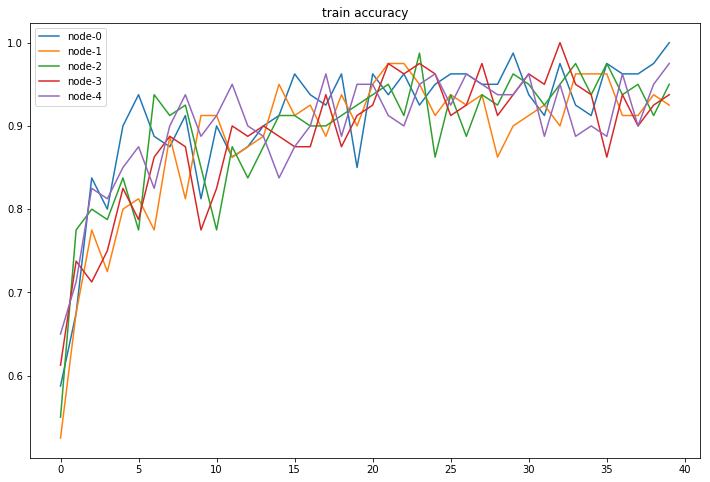

In [5]:
plt.figure(0,(12,8))
plt.title("train accuracy")
for i in range(n_learners):
    plt.plot(train_acc[i], label="node-{}".format(i))
plt.legend()

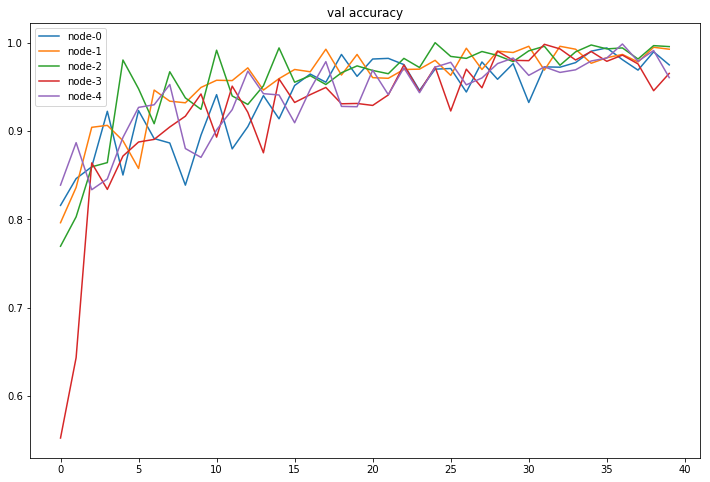

In [6]:
plt.figure(0,(12,8))
plt.title("val accuracy")
for i in range(n_learners):
    plt.plot(val_acc[i], label="node-{}".format(i))
plt.legend()

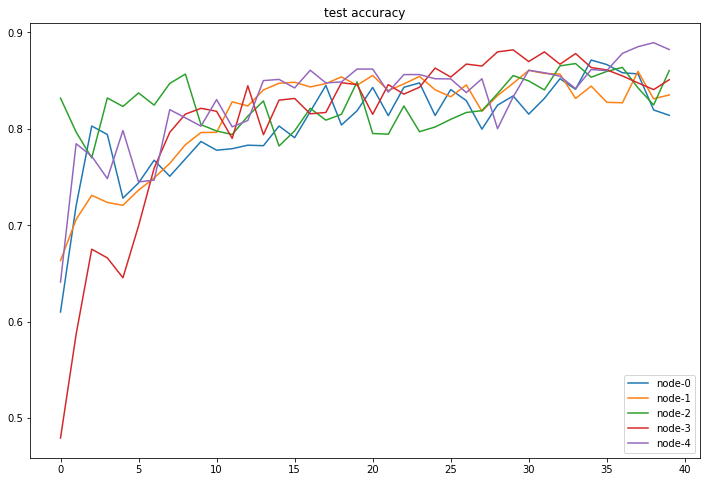

In [7]:
plt.figure(0,(12,8))
plt.title("test accuracy")
for i in range(n_learners):
    plt.plot(test_acc[i], label="node-{}".format(i))
plt.legend()

In [ ]:
learners[0].config.evaluation_config

In [8]:
l=30

In [9]:
tt = []
for i in range(n_learners):
    tt.append(np.array(test_acc[i]).reshape(1,len(test_acc[i])))
acc=np.concatenate(tt, axis=0)

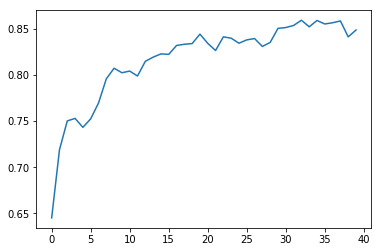

In [10]:
plt.plot(np.average(acc, axis=0))

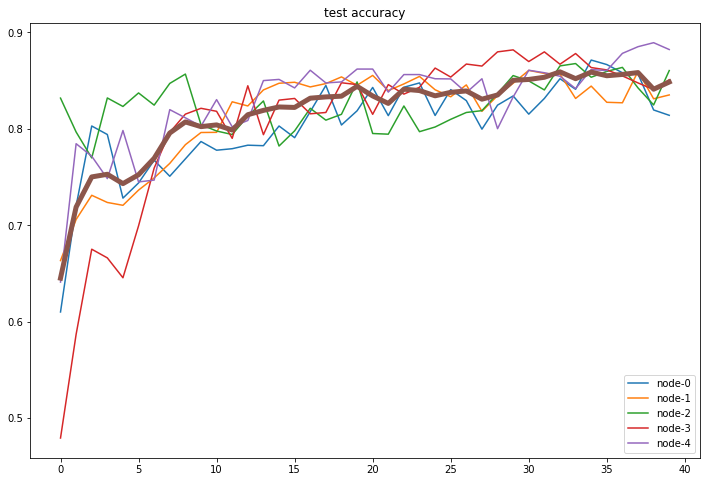

In [11]:
plt.figure(0,(12,8))
plt.title("test accuracy")
for i in range(n_learners):
    plt.plot(test_acc[i], label="node-{}".format(i))
plt.plot(np.average(acc, axis=0),lw=5)
plt.legend()

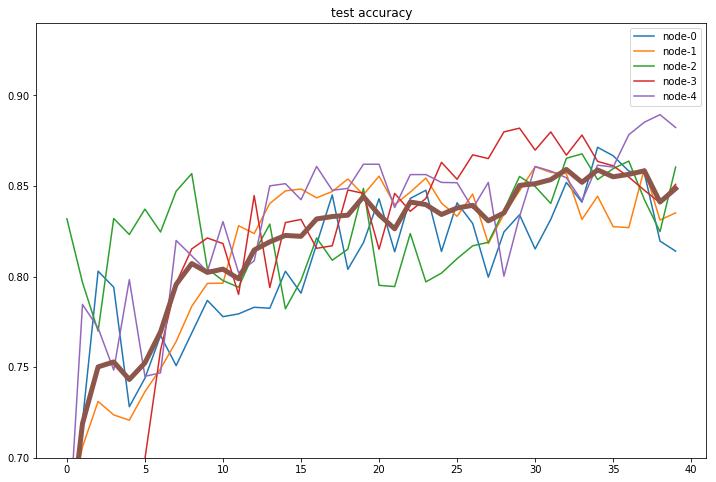

In [30]:
plt.figure(0,(12,8))
plt.title("test accuracy")
plt.ylim(0.7, 0.94)
for i in range(n_learners):
    plt.plot(test_acc[i], label="node-{}".format(i))
plt.plot(np.average(acc, axis=0),lw=5)
plt.legend()

In [19]:
lines=[]
with open("/Users/qati/Downloads/grafana_data_export(3).csv", "r") as f:
    reader=csv.reader(f)
    for r in reader:
        lines.append(r)

In [20]:
nodes={}

In [21]:
for l in lines[1:]:
    s = l[0].split(";")
    if s[2]=="null":
        continue
    nodes.setdefault(s[0],[]).append(s[2])

In [22]:
tc=[]
for _, v in nodes.items():
    a=np.array(list(map(lambda x: float(x), v)))
    tc.append(a)
    print(a.shape)

(369,)
(395,)
(387,)
(389,)
(384,)


In [24]:
tc2=[]
for a in tc:
    tc2.append(a[(a.shape[0]-350):].reshape((1,350)))
cdata = np.concatenate(tc2, axis=0)

In [25]:
n_learners=5

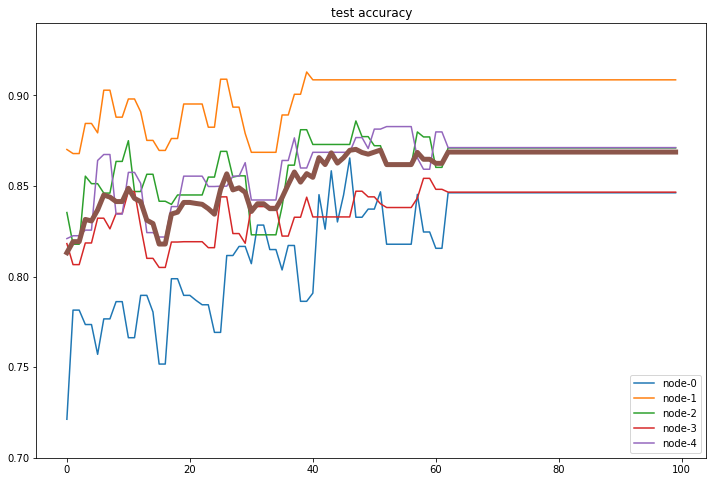

In [47]:
plt.figure(0,(12,8))
plt.title("test accuracy")
plt.ylim(0.7, 0.94)
for i in range(n_learners):
    plt.plot(cdata[i,:100], label="node-{}".format(i))
plt.plot(np.average(cdata, axis=0)[:100],lw=5)
plt.legend()